In [2]:
import torch
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='svg'
%matplotlib inline
from a2c.model import Policy
from microgrid import MG_for_test
from env_compared import MG_compared_for_test

In [2]:
#import torch.optim as optim
env = MG_for_test(assign_credit = True, privacy_preserving = False)
actor_critic = Policy(
    env.observation_space.shape,
    env.action_space.shape,
    base_kwargs={'recurrent': False,'assign_credit':True})
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
actor_critic.to(device)
#policy = A2C(args, net, optimizer, device)
checkpoint = torch.load('./models/full_multi_values/current')
actor_critic.base.load_state_dict(checkpoint['model_state_dict'],strict=False)
actor_critic.base.eval()
observations = np.zeros([12*24,env.observation_space.shape[0]])
T2 = np.zeros([12*24,10])
env.seed(9)
obs = env.reset()
recurrent_hidden_states = torch.zeros(1, actor_critic.recurrent_hidden_state_size, device=device)
mask = torch.zeros(1, 1, device=device)
done = False
i=0
while done == False:
    with torch.no_grad():
        _, action, recurrent_hidden_states = actor_critic.act(
            torch.tensor(env.obs_scalar(obs),dtype=torch.float).unsqueeze(0).to(device), recurrent_hidden_states, mask)
    # Obser reward and next obs
    obs, cost, done, info = env.move(action.detach().cpu().numpy()[0])
    observations[i] = obs
    T2[i] = env.ACs_T
    i+=1
    eval_masks = torch.tensor(
        [[0.0] if done else [1.0]],
        dtype=torch.float,
        device=device)

In [3]:
#import torch.optim as optim
env =  MG_compared_for_test(True)
actor_critic = Policy(
    env.observation_space.shape,
    env.action_space.shape,
    base_kwargs={'recurrent': True,'assign_credit':True})
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
actor_critic.to(device)
#policy = A2C(args, net, optimizer, device)
checkpoint = torch.load('./models/compared/best')
actor_critic.base.load_state_dict(checkpoint['model_state_dict'],strict=False)
actor_critic.base.eval()
T3 = np.zeros([12*24,10])
#P2 = np.zeros([12*24,10])

env.seed(9)
obs = env.reset()
recurrent_hidden_states = torch.zeros(1, actor_critic.recurrent_hidden_state_size, device=device)
mask = torch.zeros(1, 1, device=device)
done = False
i=0
while done == False:
    with torch.no_grad():
        _, action, recurrent_hidden_states = actor_critic.act(
            torch.tensor(env.obs_scalar(obs),dtype=torch.float).unsqueeze(0).to(device), recurrent_hidden_states, mask)
    # Obser reward and next obs
    obs, cost, done, info = env.move(action.detach().cpu().numpy()[0])
    T3[i] = env.ACs_T
    #P2[i] = info['P_AC']
    i+=1
    eval_masks = torch.tensor(
        [[0.0] if done else [1.0]],
        dtype=torch.float,
        device=device)

In [5]:
env = MG_for_test(True,True)
actor_critic = Policy(
    env.observation_space.shape,
    env.action_space.shape,
    base_kwargs={'recurrent': True,'assign_credit':True})
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
actor_critic.to(device)
#policy = A2C(args, net, optimizer, device)
checkpoint = torch.load('./models/multi_values/best')
actor_critic.base.load_state_dict(checkpoint['model_state_dict'],strict=False)
actor_critic.base.eval()
observations = np.zeros([12*24,env.observation_space.shape[0]])
P_EV = np.zeros([12*24,5])
P_AC = np.zeros([12*24,10])
env.seed(9)
obs = env.reset()
recurrent_hidden_states = torch.zeros(1, actor_critic.recurrent_hidden_state_size, device=device)
mask = torch.zeros(1, 1, device=device)
done = False
i=0
while done == False:
    with torch.no_grad():
        _, action, recurrent_hidden_states = actor_critic.act(
            torch.tensor(env.obs_scalar(obs),dtype=torch.float).unsqueeze(0).to(device), recurrent_hidden_states, mask)
    # Obser reward and next obs
    obs, cost, done, info = env.move(action.detach().cpu().numpy()[0])
    observations[i] = obs
    P_EV[i] = info['P_EV']
    P_AC[i] = info['P_AC']
    i+=1
    eval_masks = torch.tensor(
        [[0.0] if done else [1.0]],
        dtype=torch.float,
        device=device)

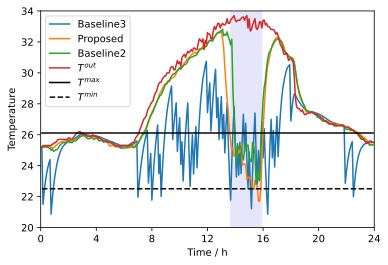

In [12]:
n=4
plt.plot(observations[:-1,0],T3[:-1,n],label='Baseline3')
plt.plot(observations[:-1,0],T_AC[:-1,n],label='Proposed')
plt.plot(observations[:-1,0],T2[:-1,n],label='Baseline2')

plt.plot(observations[:-1,0],observations[:-1,4], label='$T^{out}$')
#plt.plot(np.linspace(18,35,10), T_AC[int(env.ACs_start[n]),n]*10, 'ro')
#plt.plot(np.linspace(18,35,10), T_AC[int(env.ACs_end[n]),n]*10, 'ro')
plt.fill_between(np.linspace(env.ACs_start[n]/12,env.ACs_end[n]/12,100),18*np.ones(100), 36*np.ones(100),color='lavender')
plt.plot(observations[:-1,0], env.ACs_parameter[3,n]*np.ones(12*24-1), 'k', label='$T^{max}$')
plt.plot(observations[:-1,0], env.ACs_parameter[4,n]*np.ones(287), 'k--', label='$T^{min}$')
plt.ylim(20,34)
plt.xlim(0,24)
plt.xlabel('Time / h')
plt.ylabel('T')
plt.xticks(np.linspace(0,24,7))
plt.ylabel('Temperature')
plt.xlabel('Time / h')
plt.legend()
#plt.savefig(fname='./figure/Proposed_Baseline2_T.svg',format='svg',bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [9]:
Temp = np.load('./Data/room_tem.npy')

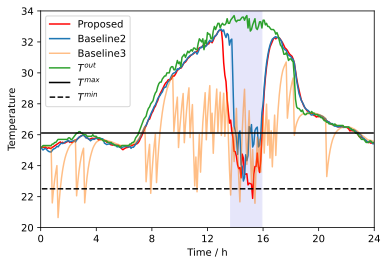

In [28]:
n=4
plt.plot(observations[:-1,0],Temp[0,:-1,n], 'r', label='Proposed')
plt.plot(observations[:-1,0],Temp[1,:-1,n],label='Baseline2')
plt.plot(observations[:-1,0],Temp[2,:-1,n],alpha=0.5,label='Baseline3')
plt.plot(observations[:-1,0],observations[:-1,4], label='$T^{out}$')
#plt.plot(np.linspace(18,35,10), T_AC[int(env.ACs_start[n]),n]*10, 'ro')
#plt.plot(np.linspace(18,35,10), T_AC[int(env.ACs_end[n]),n]*10, 'ro')
plt.fill_between(np.linspace(env.ACs_start[n]/12,env.ACs_end[n]/12,100),18*np.ones(100), 36*np.ones(100),color='lavender')
plt.plot(observations[:-1,0], env.ACs_parameter[3,n]*np.ones(12*24-1), 'k', label='$T^{max}$')
plt.plot(observations[:-1,0], env.ACs_parameter[4,n]*np.ones(287), 'k--', label='$T^{min}$')
#plt.arrow(x=env.ACs_start[n]/12,y=35,dx=0,dy=-1)
plt.ylim(20,34)
plt.xlim(0,24)
plt.xlabel('Time / h')
plt.ylabel('T')
plt.xticks(np.linspace(0,24,7))
plt.ylabel('Temperature')
plt.xlabel('Time / h')
plt.legend()
plt.savefig(fname='./figure/indoor_temperature.svg',format='svg',bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [10]:
Temp[0]

(3, 288, 10)

In [29]:
(88.62-75.61)/88.62

0.14680658993455206

In [30]:
(68.03-57.23)/(88.62-75.61)

0.830130668716372

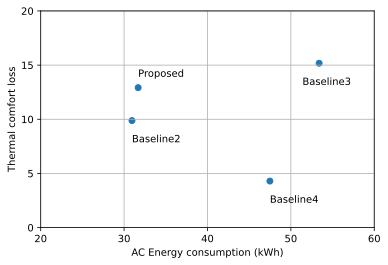

In [60]:
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='svg'
%matplotlib inline
x = [31.68553666951899,30.94626969544445,53.38750000000001,47.48558063812281]
y = [12.92075597816355, 9.879030281718226, 15.170628428350824, 4.2944831432261825]
plt.scatter(x,y)

plt.text(x[0],y[0]+1,'Proposed')
#plt.text(x[1]+2,y[1]-1,'Baseline1',fontsize=15)
plt.text(x[1],y[1]-2,'Baseline2')
plt.text(x[2]-2,y[2]-2,'Baseline3')
plt.text(x[3],y[3]-2,'Baseline4')
plt.ylim(0,20)
plt.xlim(20,60)
plt.xticks([20,30,40,50,60])
plt.yticks([0,5,10,15,20])
plt.grid()
plt.xlabel('AC Energy consumption (kWh)')
plt.ylabel('Thermal comfort loss')
plt.savefig(fname='./figure/consumption_loss.svg',format='svg',bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [1]:
import torch
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='svg'
%matplotlib inline
from a2c.model import Policy
from microgrid import MG_for_test
from env_compared import MG_compared_for_test
load = np.load('./Data/load_5min.npy')
PV= np.load('./Data/PV_5min.npy')

In [2]:
env = MG_for_test(True,True)
actor_critic = Policy(
    env.observation_space.shape,
    env.action_space.shape,
    base_kwargs={'recurrent': True,'assign_credit':True})
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
actor_critic.to(device)
#policy = A2C(args, net, optimizer, device)
checkpoint = torch.load('./models/multi_values/best')
actor_critic.base.load_state_dict(checkpoint['model_state_dict'],strict=False)
actor_critic.base.eval()
observations = np.zeros([12*24,env.observation_space.shape[0]])
P_EV = np.zeros([12*24,5])
E_EV = np.zeros([12*24,5])
P_AC = np.zeros([12*24,10])
T_AC = np.zeros([12*24,10])
costs = np.zeros([12*24,16])
env.seed(1)
obs = env.reset()
recurrent_hidden_states = torch.zeros(1, actor_critic.recurrent_hidden_state_size, device=device)
mask = torch.zeros(1, 1, device=device)
done = False
i=0
while done == False:
    with torch.no_grad():
        _, action, recurrent_hidden_states = actor_critic.act(
            torch.tensor(env.obs_scalar(obs),dtype=torch.float).unsqueeze(0).to(device), recurrent_hidden_states, mask)
    # Obser reward and next obs
    obs, cost, done, info = env.move(action.detach().cpu().numpy()[0])
    observations[i] = obs
    E_EV[i] = env.EVs_demand
    P_EV[i] = info['P_EV']
    T_AC[i] = env.ACs_T
    costs[i] = cost
    P_AC[i] = info['P_AC']
    i+=1
    eval_masks = torch.tensor(
        [[0.0] if done else [1.0]],
        dtype=torch.float,
        device=device)

In [3]:
checkpoint = torch.load('./models/user_first/best')
actor_critic.base.load_state_dict(checkpoint['model_state_dict'],strict=False)
actor_critic.base.eval()
observations4 = np.zeros([12*24,env.observation_space.shape[0]])
P_EV4 = np.zeros([12*24,5])
E_EV4 = np.zeros([12*24,5])
P_AC4 = np.zeros([12*24,10])
T_AC4 = np.zeros([12*24,10])
costs4 =  np.zeros([12*24,16])
env.seed(1)
obs = env.reset()
recurrent_hidden_states = torch.zeros(1, actor_critic.recurrent_hidden_state_size, device=device)
mask = torch.zeros(1, 1, device=device)
done = False
i=0
while done == False:
    with torch.no_grad():
        _, action, recurrent_hidden_states = actor_critic.act(
            torch.tensor(env.obs_scalar(obs),dtype=torch.float).unsqueeze(0).to(device), recurrent_hidden_states, mask)
    # Obser reward and next obs
    obs, cost, done, info = env.move(action.detach().cpu().numpy()[0])
    observations4[i] = obs
    E_EV4[i] = env.EVs_demand
    P_EV4[i] = info['P_EV']
    T_AC4[i] = env.ACs_T
    P_AC4[i] = info['P_AC']
    costs4[i] = cost
    i+=1
    eval_masks = torch.tensor(
        [[0.0] if done else [1.0]],
        dtype=torch.float,
        device=device)
    #obs = eval_envs.partial_reset(done)
#eval_envs.close()

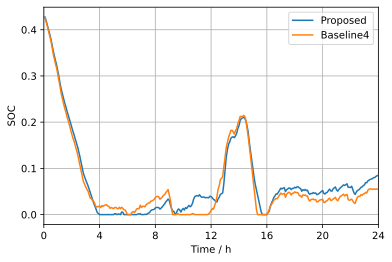

In [4]:
plt.plot(observations[:-1,0],observations[:-1,3],label='Proposed')
plt.plot(observations[:-1,0],observations4[:-1,3],label='Baseline4')
#plt.ylim(0,1.05)
plt.xlim(0,24)
plt.xlabel('Time / h')
plt.ylabel('SOC')
plt.xticks(np.linspace(0,24,7))
plt.legend()
plt.grid()
#plt.savefig(fname='./figure/soc.svg',format='svg')
plt.show()

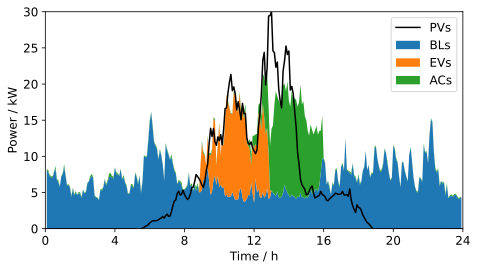

In [38]:
fig, (ax1) = plt.subplots(1, 1, sharey=True, figsize=(7.5, 4))
pv = PV[env.index-287:env.index]*0.08
lo = load[env.index-287:env.index]*0.2
ax1.plot(observations[:-1,0],pv,'k',label='PVs')
#plt.plot(observations[:-1,0],observations[:-1,2]+pv,'r',label='PG')
ax1.fill_between(observations[:-1,0],lo,label='BLs')
ax1.fill_between(observations[:-1,0],lo,lo+P_EV.sum(axis=1)[1:],label='EVs')
ax1.fill_between(observations[:-1,0],lo+P_EV.sum(axis=1)[1:],lo+P_EV.sum(axis=1)[1:]+P_AC.sum(axis=1)[1:],label='ACs')
ax1.set_xlim(0,24)
ax1.set_ylim(0,30)
ax1.set_xlabel('Time / h',fontsize=12)
ax1.set_ylabel('Power / kW',fontsize=12)
ax1.legend(fontsize=12)
plt.xticks([0,4,8,12,16,20,24],fontsize=12)
plt.yticks([0,5,10,15,20,25,30],fontsize=12)
plt.savefig(fname='./figure/loads_proposed.svg',format='svg',bbox_inches = 'tight', pad_inches = 0)
plt.show()

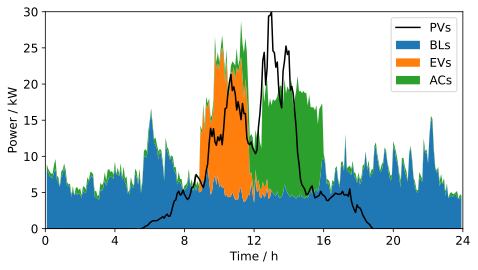

In [39]:
fig, (ax2) = plt.subplots(1, 1, sharey=True, figsize=(7.5, 4))
ax2.plot(observations[:-1,0],pv,'k',label='PVs')
#plt.plot(observations[:-1,0],observations4[:-1,2]+pv,'r',label='PG')
ax2.fill_between(observations[:-1,0],lo,label='BLs')
ax2.fill_between(observations[:-1,0],lo,lo+P_EV4.sum(axis=1)[1:],label='EVs')
ax2.fill_between(observations[:-1,0],lo+P_EV4.sum(axis=1)[1:],lo+P_EV4.sum(axis=1)[1:]+P_AC4.sum(axis=1)[1:],label='ACs')
ax2.set_xlim(0,24)
ax2.set_ylim(0,30)
ax2.set_xlabel('Time / h',fontsize=12)
ax2.set_ylabel('Power / kW',fontsize=12)
plt.xticks([0,4,8,12,16,20,24],fontsize=12)
plt.yticks([0,5,10,15,20,25,30],fontsize=12)
ax2.legend(fontsize=12)
plt.savefig(fname='./figure/loads_baseline4.svg',format='svg',bbox_inches = 'tight', pad_inches = 0)
plt.show()

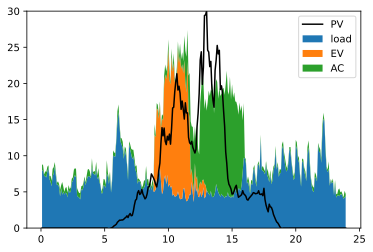

In [6]:
start = env.total_steps*env.num_days

plt.show()

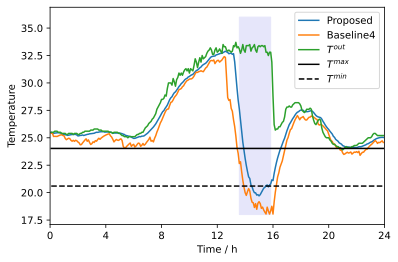

In [20]:
n=9
plt.plot(observations[:-1,0],T_AC[:-1,n],label='Proposed')
plt.plot(observations[:-1,0],T_AC4[:-1,n], label='Baseline4')
#plt.plot(observations[:-1,0],observations[:-1,4], label='$T^{out}$')
plt.plot(observations[:-1,0],observations4[:-1,4], label='$T^{out}$')
#plt.plot(np.linspace(18,35,10), T_AC[int(env.ACs_start[n]),n]*10, 'ro')
#plt.plot(np.linspace(18,35,10), T_AC[int(env.ACs_end[n]),n]*10, 'ro')
plt.fill_between(np.linspace(env.ACs_start[n]/12,env.ACs_end[n]/12,100),18*np.ones(100), 36*np.ones(100),color='lavender')
plt.plot(observations[:-1,0], env.ACs_parameter[3,n]*np.ones(12*24-1), 'k', label='$T^{max}$')
plt.plot(observations[:-1,0], env.ACs_parameter[4,n]*np.ones(287), 'k--', label='$T^{min}$')
#plt.ylim(20,34)
plt.xlim(0,24)
plt.xticks(np.linspace(0,24,7))
plt.ylabel('Temperature')
plt.xlabel('Time / h')
plt.legend()
#plt.savefig(fname='./figure/Proposed_Baseline2_T.svg',format='svg',bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [8]:
costs.sum(axis=0)[1:].sum()

38.60253592504084

In [9]:
costs4.sum(axis=0)[1:].sum()

21.49858442139374

In [10]:
costs.sum(axis=0)[0]

95.18661334561068

In [11]:
costs4.sum(axis=0)[0]

184.17075765747023

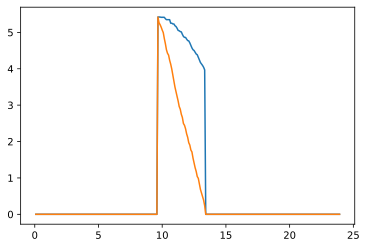

In [22]:
n=4
plt.plot(observations[:-1,0],E_EV[:-1,n],label='Proposed')
plt.plot(observations[:-1,0],E_EV4[:-1,n], label='Baseline4')
plt.show()

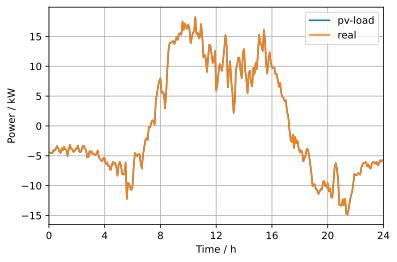

In [28]:
plt.plot(observations[:-1,0], (PV[start+1:start+288]*0.08-load[start+1:start+288]*0.2), label='pv-load')
plt.plot(observations[:-1,0], observations[:-1,1], label='real')
#plt.plot(x[:,0], x[:,2]-x[:,1]-x[:,3]-x[:,4]-x[:,5], label='Pbes')
#plt.ylim(0,100)
plt.xlim(0,24)
plt.xticks(np.linspace(0,24,7))
plt.xlabel('Time / h')
plt.ylabel('Power / kW')
plt.grid()
plt.legend()
#plt.savefig(fname='./figure/pv_load.svg',format='svg')
plt.show()

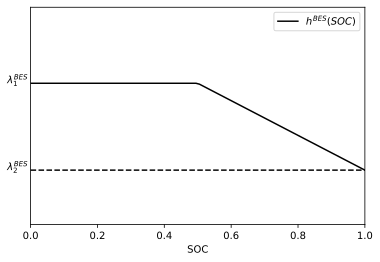

In [3]:
x = np.linspace(0,1,100)
lambda1 = 0.13
lambda2 = 0.05
y = lambda1 + (lambda1-lambda2)*(1-2*x) * (x>=0.5)
plt.plot(x,y, 'k', label='$h^{BES}(SOC)$')
plt.plot(x,lambda2*np.ones(100),'--k')
plt.xlim(0,1)
plt.ylim(0,0.2)
plt.text(-0.07,0.13,'$\lambda^{BES}_1$')
plt.text(-0.07,0.05,'$\lambda^{BES}_2$')
plt.yticks([])
plt.xlabel('SOC')
plt.legend()
plt.savefig(fname='./figure/hBES.svg',format='svg',bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [1]:
import torch
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='svg'
%matplotlib inline

In [2]:
PV = np.load('./Data/PV_5min.npy')
Load = np.load('./Data/load_5min.npy')

TypeError: 'tuple' object is not callable

In [3]:
len(PV)

17856

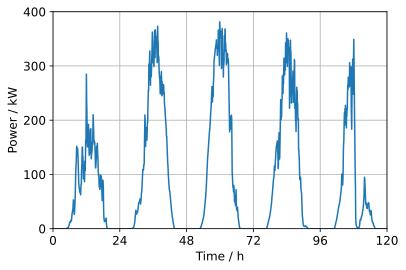

In [25]:
day =5
t = np.linspace(0,24*day,24*12*day)
plt.plot(t, PV[:24*12*day])
plt.ylim(0,400)
plt.yticks(np.linspace(0,400,5),fontsize=12)
plt.xlim(0,24*day)
plt.xticks(np.linspace(0,24*day,day+1),fontsize=12)
plt.xlabel('Time / h',fontsize=12)
plt.ylabel('Power / kW',fontsize=12)
plt.grid()
plt.savefig(fname='./figure/PV.pdf',format='pdf',bbox_inches = 'tight', pad_inches = 0)
plt.show()

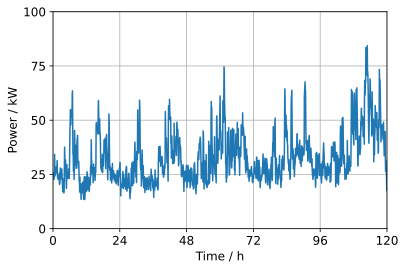

In [24]:
day =5
t = np.linspace(0,24*day,24*12*day)
plt.plot(t, Load[:24*12*day])
plt.ylim(0,100)
plt.yticks(np.linspace(0,100,5),fontsize=12)
plt.xlim(0,24*day)
plt.xticks(np.linspace(0,24*day,day+1),fontsize=12)
plt.xlabel('Time / h',fontsize=12)
plt.ylabel('Power / kW',fontsize=12)
plt.grid()
plt.savefig(fname='./figure/load.pdf',format='pdf',bbox_inches = 'tight', pad_inches = 0)
plt.show()